# Airbnb & Housing Price Comparaison

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Where to save the figures
PROJECT_ROOT_DIR = ".."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple((int(value[i:i + lv // 3], 16))/255.0 for i in range(0, lv, lv // 3))

# List of discretised colors along with the limit price
colors_hex = ['#6D3735', '#B03436', '#FF343A', '#FE993D', '#FFFF47', '#AFFF48', '#61FDEC', '#48ADFB', '#4460E5', '#21377B']
colors_rgb = [hex_to_rgb(c) for c in colors_hex]
segments = [6000, 5000, 4500, 4000, 3500, 3000, 2500 , 2000, 1500, 0]

### Load housing data

In [4]:
import shapefile as shp
import pyproj
from matplotlib.patches import Polygon


# Initialise projection, code was found typing Amsterdam on this website http://spatialreference.org/
# We must do this to match the Geographical reference of the Airbnb data set
p = pyproj.Proj(init='EPSG:7415')

# In this dict we store the shape file for each year
housing_prices = {}

# Load each shapefile and store in the dict
for i in range(2003, 2016):
    path = "../data/WONINGWAARDE/WONINGWAARDE_" + str(i) + "_INFLATIE_region.shp"
    housing_prices[i]= shp.Reader(path)
        
# We create two dicts, one to store polygons for fast draw and the other for raw points for later calculations
housing_prices_shapes = {}
housing_prices_polygons = {}

for h in housing_prices:
    housing_prices_shapes[h] = []
    housing_prices_polygons[h] = []
    for j, shape in enumerate(housing_prices[h].shapeRecords()):
        pos = np.asarray([p(i[0], i[1], inverse=True) for i in shape.shape.points[:]])
        housing_prices_shapes[h].append(pos)
        housing_prices_polygons[h].append(
            Polygon(
                pos,     # (x,y)
                closed=True, # number of vertices
            )
        )

# Load the prices for each year
housing_prices_price = {}
for h in housing_prices:
    housing_prices_price[h] = [shape.__dict__['record'][3] for shape in housing_prices[h].shapeRecords()]

### Plot the shape with price for each year

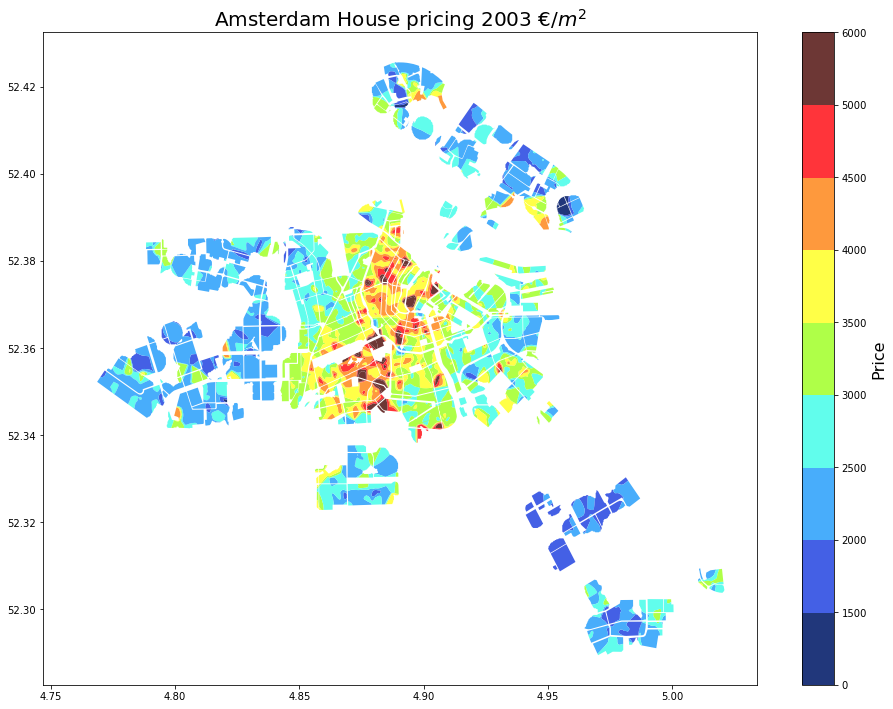

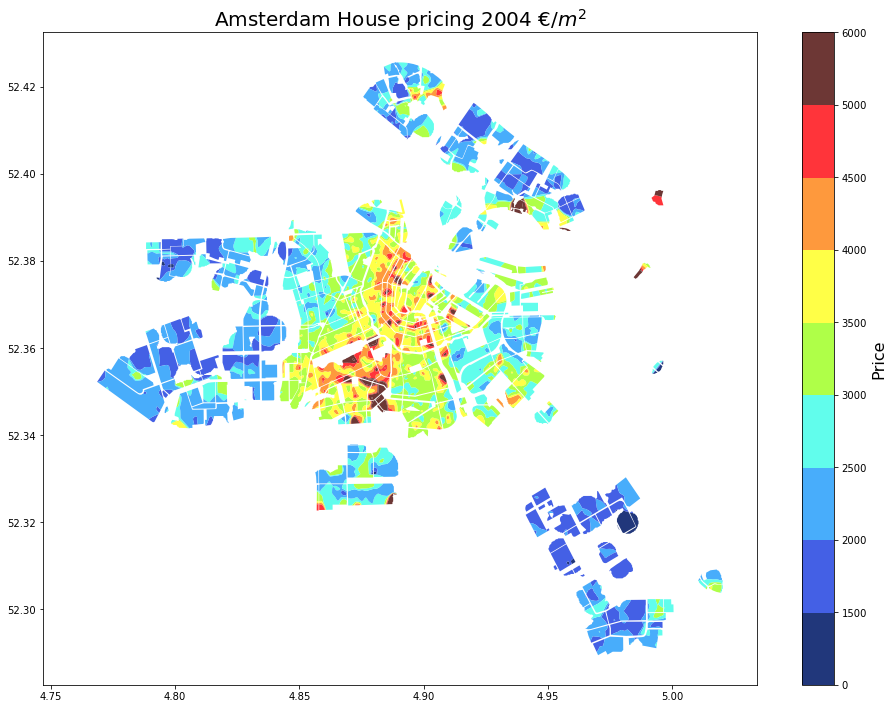

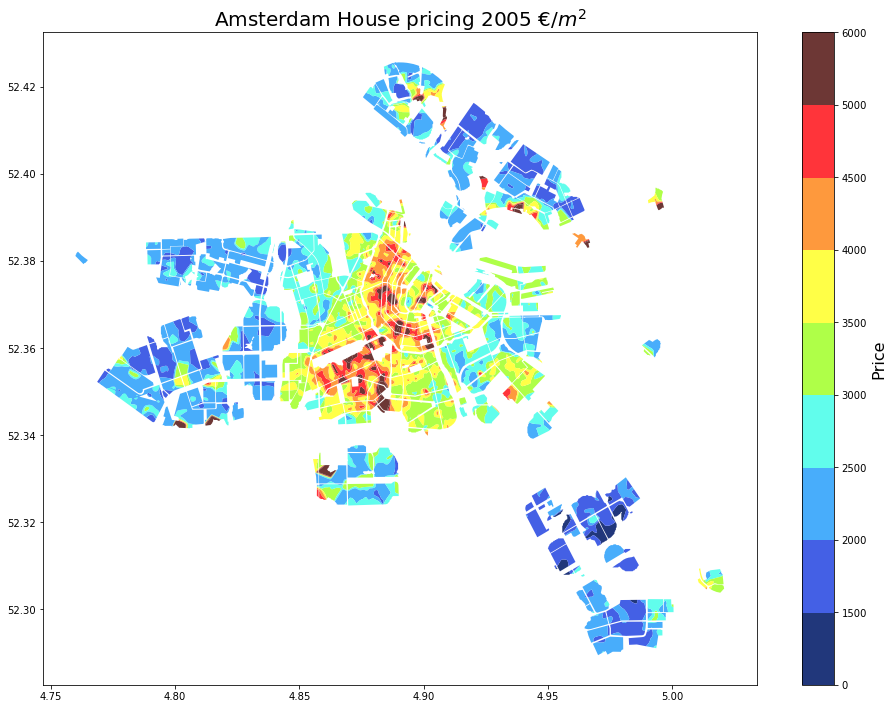

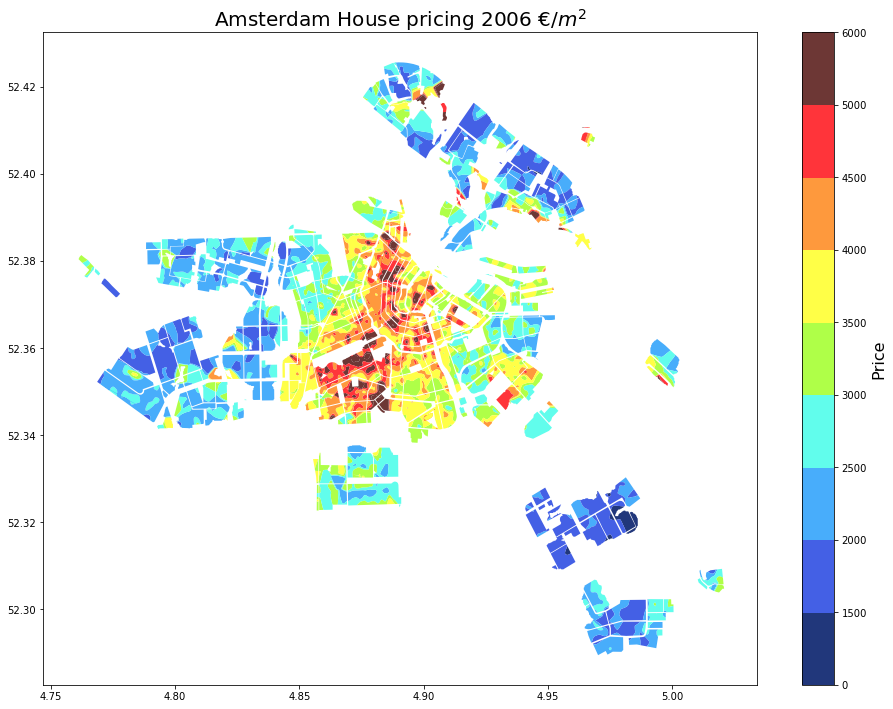

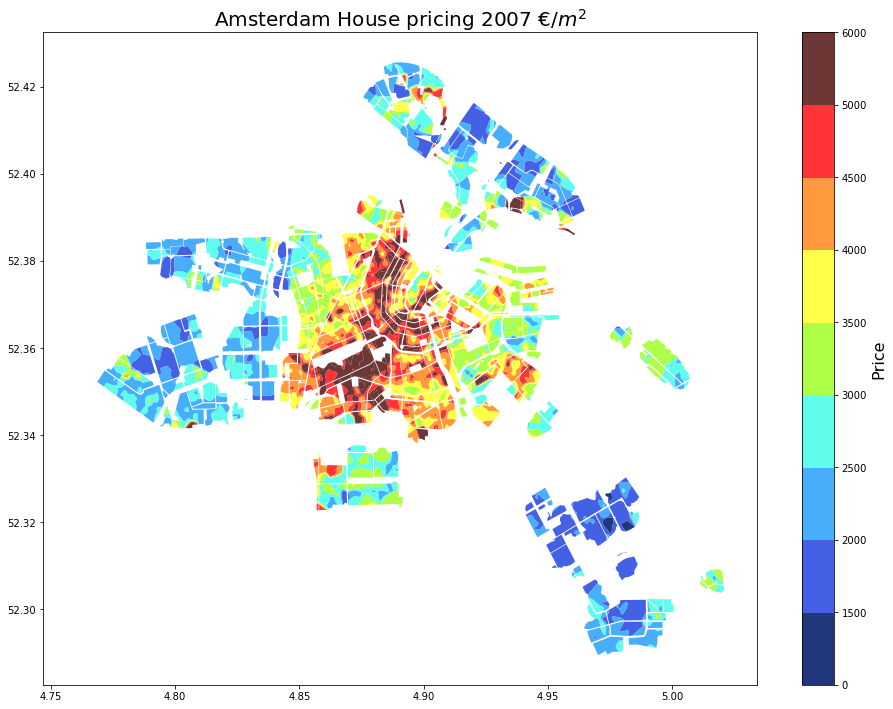

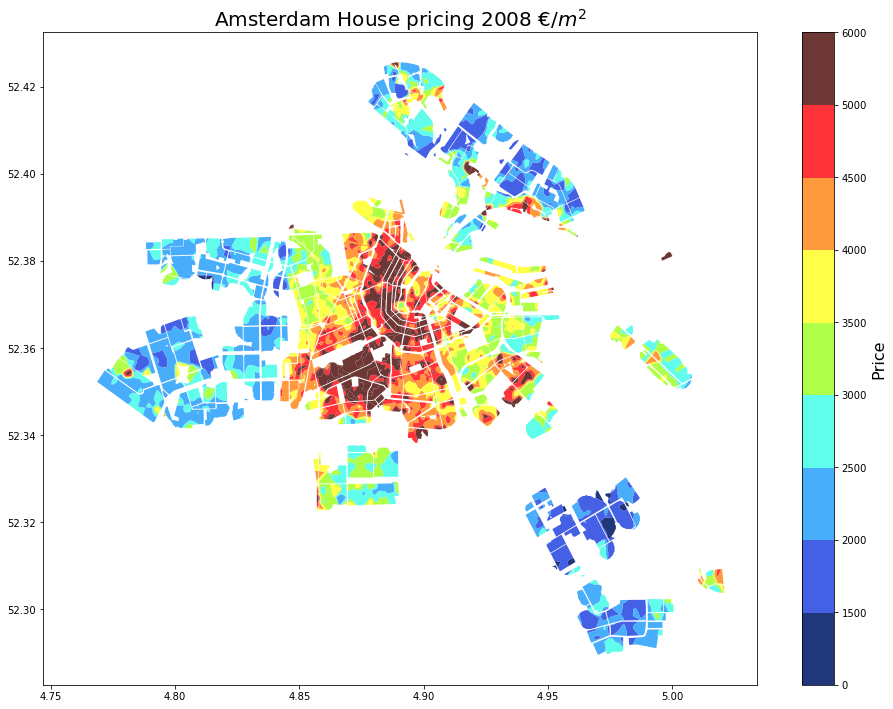

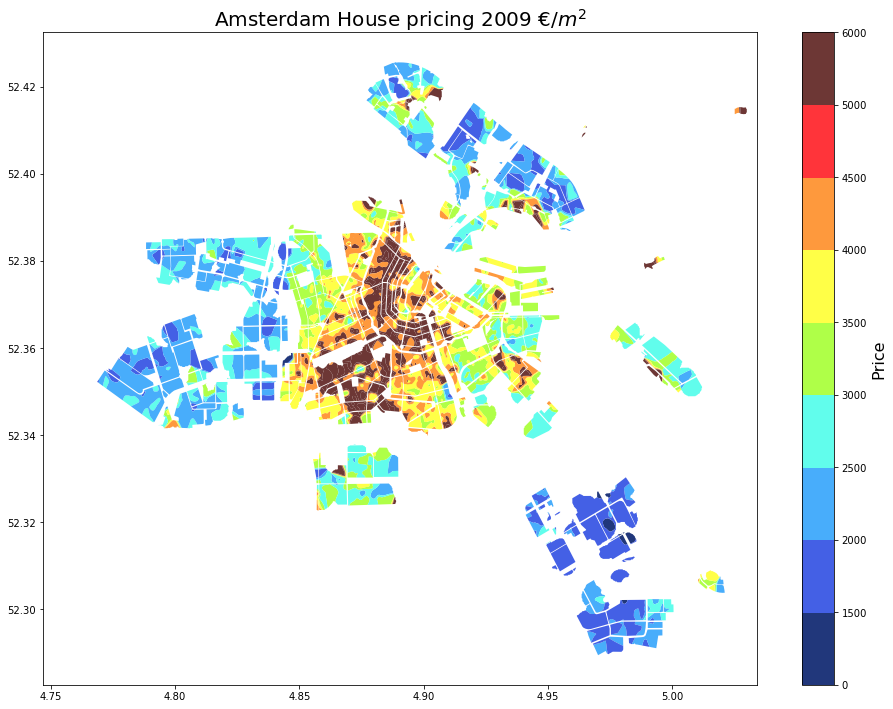

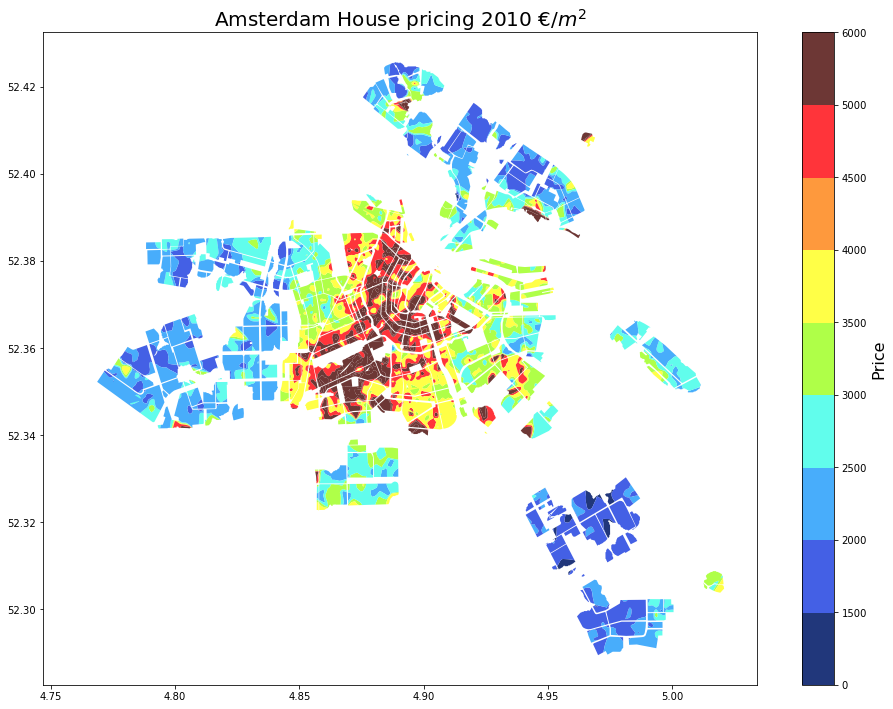

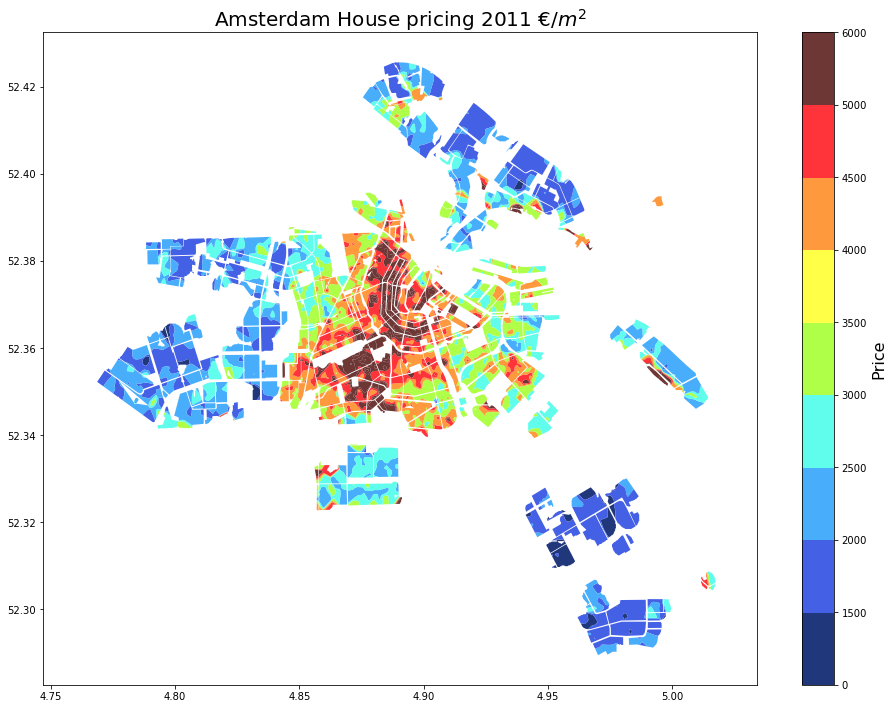

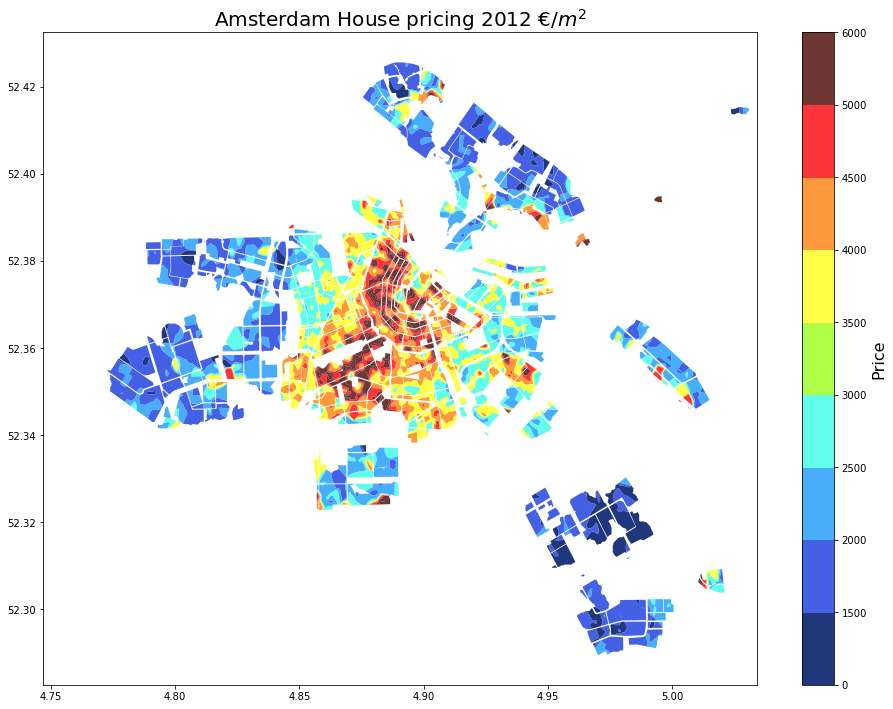

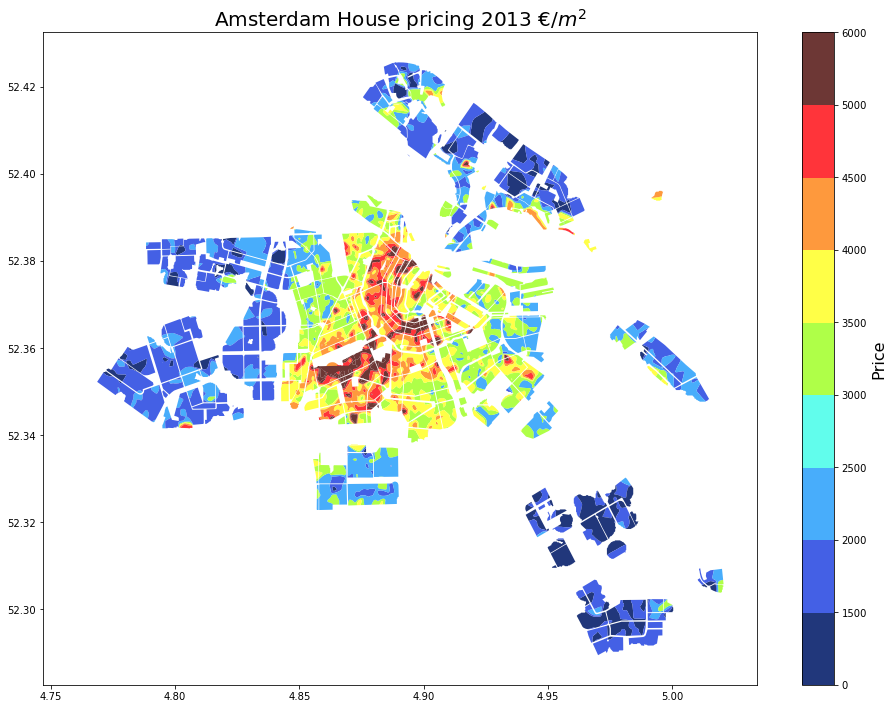

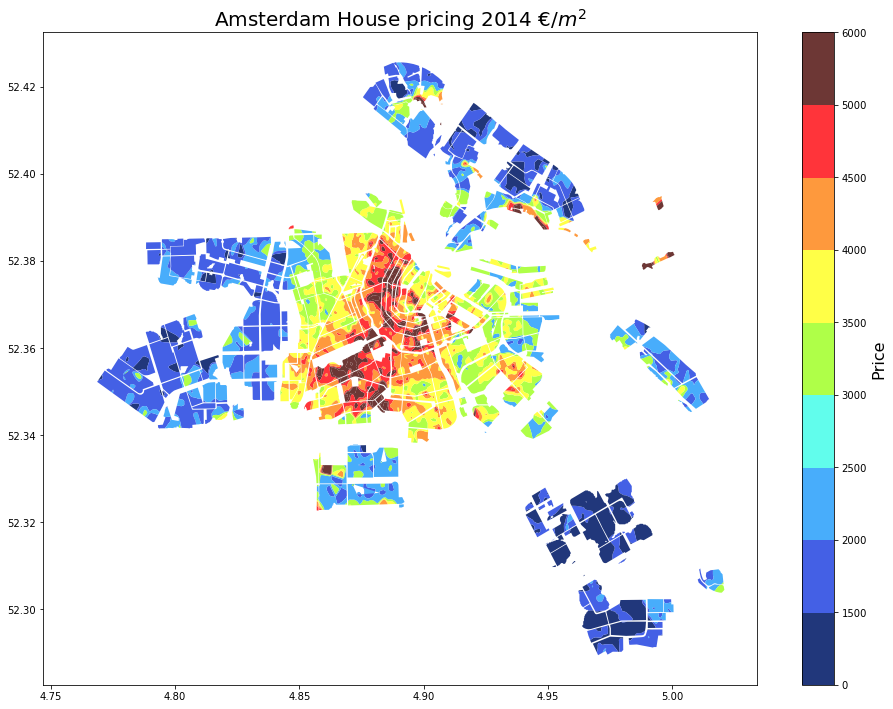

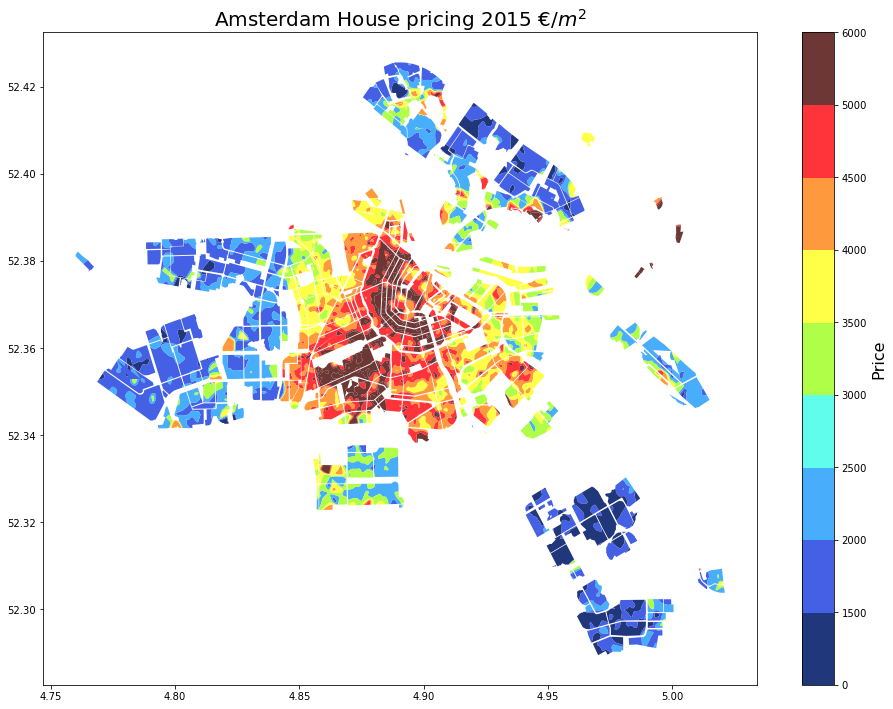

In [5]:
from matplotlib.collections import PatchCollection
import matplotlib

# We pre calculated this so all maps line up
axis = [4.7469287189121001, 5.0340994897259534, 52.282706941081258, 52.432452803031282]

for h in housing_prices:

    fig, ax = plt.subplots(figsize=(16,12))

    cmap = matplotlib.colors.ListedColormap(colors_hex[::-1])
    norm = matplotlib.colors.BoundaryNorm(segments[::-1], cmap.N)

    p = PatchCollection(housing_prices_polygons[h], cmap=cmap, norm=norm, alpha=1)

    prices = np.array(housing_prices_price[h]).astype(int)
    p.set_array(prices)

    ax.set_title(r'Amsterdam House pricing %s $€/m^2$' % h , size=20) # Title

    ax.add_collection(p)
    ax.axis(axis)
    fig.colorbar(p, ax=ax).set_label('Price', size=16) #, ticks=np.arange(np.min(prices),np.max(prices)+1)
    #save_fig(h) # Uncomment this to save as png's

### Computer YoY Growth

Saving figure Percentage_Change


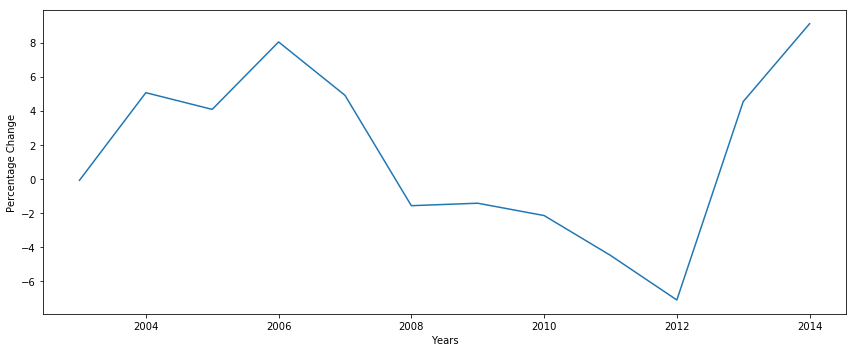

In [82]:
yoy_growth = []
years = []

for y in housing_prices_price:
    if y < 2015:
        y1 = np.asarray(housing_prices_price[y]).astype(np.float).mean()
        y2 = np.array(housing_prices_price[y+1]).astype(np.float).mean()
        yoy =  (1-y1/y2)*100
        yoy_growth.append(yoy)
        years.append(y)

plt.figure(figsize=(12, 5))
plt.plot(years, yoy_growth);
plt.ylabel('Percentage Change')
plt.xlabel('Years')
save_fig('Percentage_Change')

In [64]:
yoy_growth[-1]

0.90888732539098527

### Load the Airbnb Data

In [5]:
# NOTE: Each dataset contains different features
import pandas as pd

airbnb_prices = {}

airbnb_prices[2015] = pd.read_csv("../data/airbnb/listings-2015.csv")
airbnb_prices[2016] = pd.read_csv("../data/airbnb/listings-2016.csv")
airbnb_prices[2017] = pd.read_csv("../data/airbnb/listings-2017.csv")

# 2017 has commas and dollar signs we need to remove
airbnb_prices[2017].price = airbnb_prices[2017].price.str.replace(r'[$,]', '').astype(float)

### Draw a heatmap using listings and price as weight

In [6]:
import gmaps

gmaps.configure(api_key="INSERT GOOGLE MAPS API KEY")

fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    airbnb_prices[2017][["latitude", "longitude"]], weights=airbnb_prices[2017].price,
    max_intensity=6000, point_radius=8.0
)
fig.add_layer(heatmap_layer)
fig

Figure()

### Convert each housing shape file into matrix form for comparaison

In [117]:

# we create the a grid which will hold the density value
divs = 80
xG = np.linspace(axis[0], axis[1], divs)
yG = np.linspace(axis[2], axis[3], divs)
xv, yv = np.meshgrid(xG, yG)

housing_price_matrix = {} 

spacingX = (xv[0][0] - xv[0][1])
spacingY = (yv[0][0] - yv[1][0])

for year in housing_prices_shapes:
    
    housing_price_matrix[year] = np.zeros(xv.shape)
    
    #house prices 2014 into matrix form
    for j, shape in enumerate(housing_prices_shapes[year]):

        for i in shape:
            x = i[0] - axis[0]
            y = i[1] - axis[2]

            xN = np.floor(np.abs(x/spacingX)).astype(np.int)
            yN = np.floor(np.abs(y/spacingY)).astype(np.int)

            housing_price_matrix[year][xN][yN] =  (housing_price_matrix[year][xN][yN] + float(housing_prices_price[year][j]))/2.0


### We start by defining a custom colormap for the aibnb density

In [118]:
colors_white = colors_hex[::-1]
colors_white.insert(0, '#ffffff')
cmap = matplotlib.colors.ListedColormap(colors_white)

### For each matrix cell, get the airbnb density

In [119]:
airbnb_density_matrix = {}

for year in airbnb_prices:
    
    airbnb_density_matrix[year] = np.zeros(xv.shape)
    
    listing_coordinates = airbnb_prices[year][['longitude', 'latitude']].values
    
    for p in listing_coordinates:
        
        x = p[0] - axis[0]
        y = p[1] - axis[2]
        
        xN = np.floor(np.abs(x/spacingX)).astype(np.int)
        yN = np.floor(np.abs(y/spacingY)).astype(np.int)

        airbnb_density_matrix[year][xN][yN] += 1

Saving figure housing_price_2015


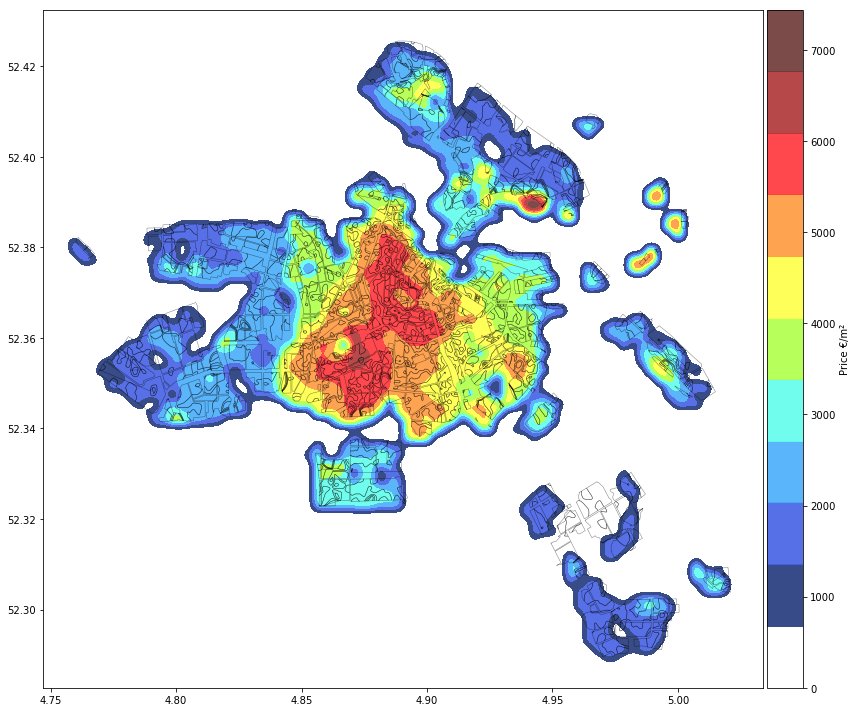

In [120]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

im = ax.imshow(np.fliplr((housing_price_matrix[2015])).T, extent=axis, cmap=cmap,  interpolation='bicubic', alpha=.9)

for s in housing_prices_shapes[2015]:
    ax.plot(s[:,0], s[:,1], linewidth=0.5, c='black', alpha=0.5)
    
ax.axis(axis)
ax.set_aspect("auto")


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = fig.colorbar(im, cax=cax)
cb.set_label("Price €/m²")

save_fig('housing_price_2015')

### For each cell within our matrix define the density of lisings within it

Saving figure airbnbDensity_2015


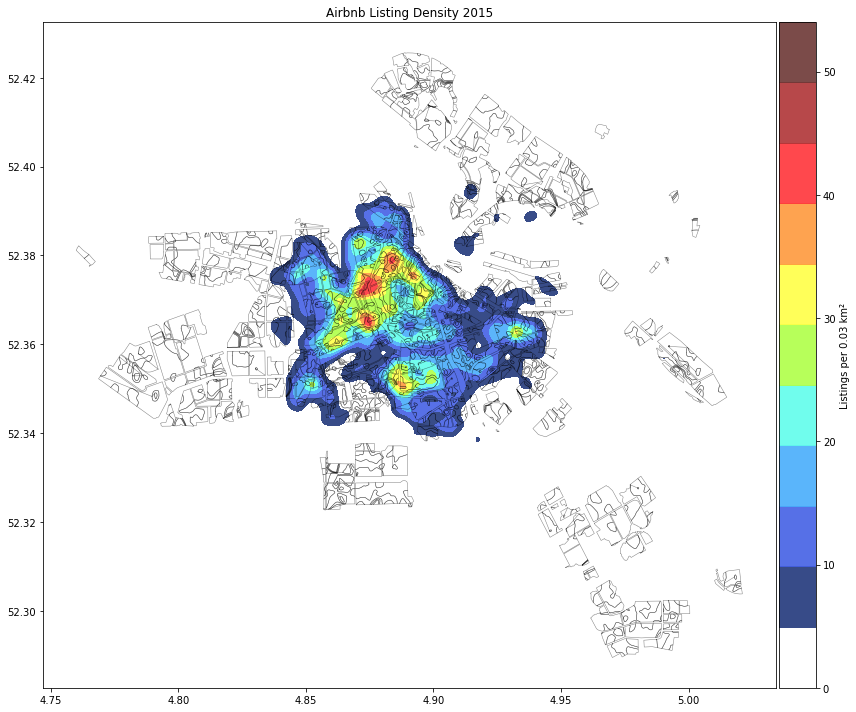

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(111)

ax1.set_title('Airbnb Listing Density 2015')

im = ax1.imshow(np.fliplr((airbnb_density_matrix[2015])).T, extent=axis, cmap=cmap, interpolation='bicubic', alpha=.9)

for s in housing_prices_shapes[2015]:
    ax1.plot(s[:,0], s[:,1], linewidth=0.5, c='black', alpha=0.5)
    
ax1.axis(axis)
ax1.set_aspect("auto")
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = fig.colorbar(im, cax=cax)
cb.set_label("Listings per 0.03 km²")

save_fig('airbnbDensity_2015')

### Let's compute price increase

In [138]:
import matplotlib.colors as mcolors

levs = range(16)
assert len(levs) % 2 == 0, 'N levels must be even.'

my_cmap2 = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0),
                                                          (1, 1., 1),
                                                          (0, 0, 1)],
                                                 N=len(levs)-1,
                                                    )

Saving figure airbnbDensity_housingDifference_2015


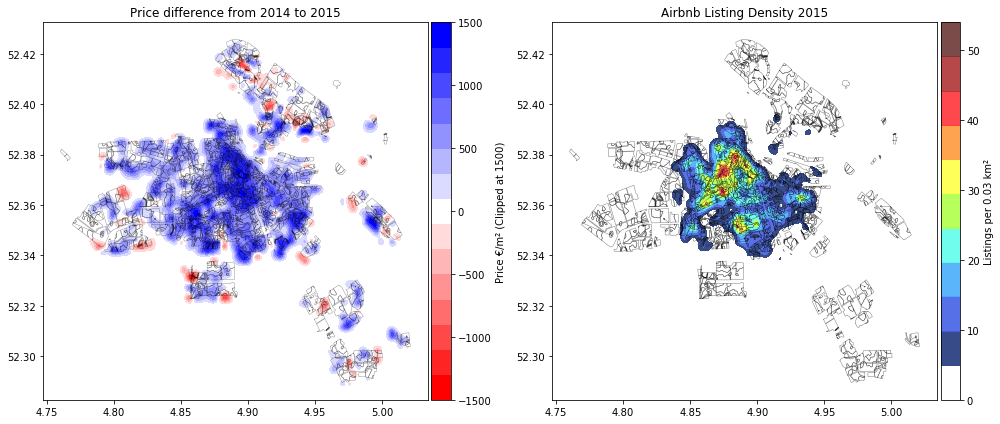

In [151]:

housing_2015_masked = np.ma.array(housing_price_matrix[2015], mask = housing_price_matrix[2015] == 0)
housing_2014_masked = np.ma.array(housing_price_matrix[2014], mask = housing_price_matrix[2014] == 0)

umask = np.logical_or(housing_2015_masked.mask, housing_2014_masked.mask) # <-- union of the masks

difference =  housing_2015_masked.data - housing_2014_masked.data
difference[umask] = 0
difference_flipped = np.fliplr((difference.data)).T

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)

# Whilst clipping is bad practice it's a simple way for us to spot any correlation
clip_value = 1500
difference_flipped_clipped = np.clip(difference_flipped, -clip_value, clip_value)

ax1.set_title('Price difference from 2014 to 2015')

im = ax1.imshow(difference_flipped_clipped, extent=axis, cmap=my_cmap2,  vmin=-clip_value, vmax=clip_value, interpolation='bicubic', alpha=1)

for s in housing_prices_shapes[2015]:
     ax1.plot(s[:,0], s[:,1], linewidth=0.5, c='black', alpha=0.4)
    
ax1.axis(axis)
ax1.set_aspect("auto")
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(im, cax=cax)
cb.set_label("Price €/m² (Clipped at %d)" % clip_value)



ax2 = fig.add_subplot(122)

ax2.set_title('Airbnb Listing Density 2015')

im = ax2.imshow(np.fliplr((airbnb_density_matrix[2015])).T, extent=axis, cmap=cmap, interpolation='bicubic', alpha=.9)

for s in housing_prices_shapes[2015]:
    ax2.plot(s[:,0], s[:,1], linewidth=0.5, c='black', alpha=0.5)
    
ax2.axis(axis)
ax2.set_aspect("auto")
    
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

cb = fig.colorbar(im, cax=cax)
cb.set_label("Listings per 0.03 km²")

save_fig('airbnbDensity_housingDifference_2015')


In [145]:
# Pearson Coefficient

from scipy.stats import pearsonr
pearsonr(difference.ravel(), airbnb_density_matrix[2015].ravel())

(0.44621609986395216, 7.5991645615174849e-311)